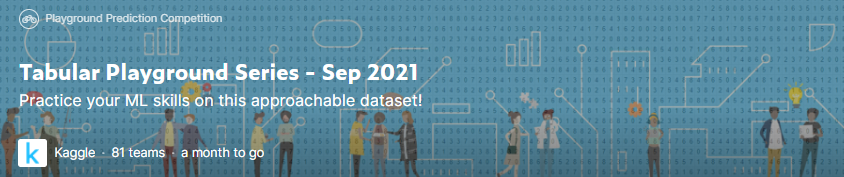

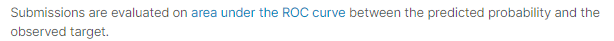

### <span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Very Simple Optuna+LightGBM</span>

In [ ]:
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
import seaborn as sns; sns.set()
import scipy as sp
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt 
import warnings
from sklearn.metrics import roc_curve
warnings.simplefilter('ignore')

 <span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Look datas</span>

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-sep-2021/train.csv')
train

In [ ]:
train.isnull().sum()

In [ ]:
target = train.claim
train = train.drop(['claim'],axis=1)

In [ ]:
target.hist()

In [ ]:
test = pd.read_csv('../input/tabular-playground-series-sep-2021/test.csv')
test

In [ ]:
scaler = StandardScaler()
feature_name = train.columns.to_list()
feature_name = feature_name[1:]
train[feature_name] = scaler.fit_transform(train[feature_name])
test[feature_name] = scaler.transform(test[feature_name])

train[feature_name] = train[feature_name].fillna(train[feature_name].mean())
test[feature_name] = test[feature_name].fillna(test[feature_name].mean())

In [ ]:
train['n_missing'] = train[feature_name].isna().sum(axis=1)
test['n_missing'] = test[feature_name].isna().sum(axis=1)

train['std'] = train[feature_name].std(axis=1)
test['std'] = test[feature_name].std(axis=1)

feature_name += ['n_missing', 'std']

In [ ]:
test.isnull().sum()

In [ ]:
sub = pd.read_csv('../input/tabular-playground-series-sep-2021/sample_solution.csv')
sub

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Optuna</span>

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
#!pip install optuna
import optuna 
import optuna.integration.lightgbm as lgbo

params = {'objective': 'binary',  'metric': 'binary_logloss','device_type':'gpu'} 
from sklearn.metrics import mean_absolute_error
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=42)
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test)
model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Training</span>

In [ ]:
best_lgb_params =model.params
best_lgb_params["learning_rate"] = 0.006
best_lgb_params["early_stopping_round"] = 200
best_lgb_params["num_iterations"] = 80000
best_lgb_params["device_type"] = 'gpu'

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
spl=5
kf = KFold(n_splits=spl, random_state=77, shuffle=True)
models =[]
for fold, (trn_idx, val_idx) in enumerate(kf.split(train, target)):

    print("Fold :", fold+1)
    
    # create dataset
    x_train, y_train = train.loc[trn_idx], target.loc[trn_idx]
    x_test,  y_test = train.loc[val_idx], target.loc[val_idx]
 
    #x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_valid = lgb.Dataset(x_test, y_test)
 
    model = lgb.train(best_lgb_params,lgb_train, valid_sets=[lgb_valid], verbose_eval=100)
    lpred = model.predict(x_test)

    models.append(model)
    
    #print('#### fold #########',roc_curve(y_test, lpred))

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Evaluation</span>

In [ ]:
lpred=[]
for model in models:
   lpred.append(model.predict(x_test))
pred=lpred[0]
for i in range(1,spl):
   pred += lpred[i]
pred = pred /spl
print('#### fold #########',roc_auc_score(y_test, pred))

<span style="color: orange; font-family: Segoe UI; font-size: 1.9em; font-weight: 300;">Inference</span>

In [ ]:

lpred=[]
for model in models:
   lpred.append(model.predict(test))
pred=lpred[0]
for i in range(1,spl):
   pred += lpred[i]
pred = pred /spl
pred

In [ ]:
sub.claim = pred
sub.to_csv('submit.csv',index=False)
sub

😺😅㊙🔰🗑⬛🟥🟨🟩